# 사전 준비

In [23]:
!pip install pennylane


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\xanle\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\xanle\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [25]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\xanle\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [26]:
!pip install tqdm


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\xanle\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [27]:
import pennylane as qml # 일반적으로 qml이란 이름으로 가져옵니다. Quantum Machine Learning의 약자입니다.
import numpy as np

from pennylane import numpy as np_p

import torch
from torch.optim import Adam
from torch.optim import AdamW
from torch.optim import RAdam
from torch.optim import Optimizer
from torch.nn.parameter import Parameter
from torch.nn import NLLLoss

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torchvision

from tqdm import tqdm

from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
print(torch.version.cuda)       # CUDA 버전 출력
print(torch.cuda.is_available())  # True여야 GPU 사용 가능

cuda
11.8
True


In [28]:
class Lion(Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super(Lion, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad

                state = self.state[p]
                if len(state) == 0:
                    state["exp_avg"] = torch.zeros_like(p)

                exp_avg = state["exp_avg"]
                beta1, beta2 = group["betas"]

                # Weight decay
                if group["weight_decay"] != 0:
                    grad = grad + group["weight_decay"] * p

                # Update exponential moving average
                exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)

                # Parameter update
                update = exp_avg * beta1 + grad * (1 - beta1)
                p.add_(update.sign(), alpha=-group["lr"])

        return loss

In [29]:
class Lookahead(Optimizer):
    def __init__(self, optimizer, alpha=0.5, k=5):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid alpha: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid k: {k}')

        defaults = optimizer.defaults if hasattr(optimizer, 'defaults') else {}
        super().__init__(optimizer.param_groups, defaults)

        self.optimizer = optimizer
        self.alpha = alpha
        self.k = k
        self.param_groups = self.optimizer.param_groups
        self.state = self.optimizer.state
        self._step = 0

        # Slow weights 초기화
        for group in self.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['slow_param'] = p.data.clone().detach()

    @torch.no_grad()
    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        self._step += 1

        if self._step % self.k != 0:
            return loss

        # Lookahead 업데이트
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                param_state = self.state[p]
                slow = param_state['slow_param']
                fast = p.data
                # slow ← slow + α(fast - slow)
                p.data = slow + self.alpha * (fast - slow)
                param_state['slow_param'] = p.data.clone().detach()

        return loss

# 데이터셋 준비

In [30]:
transform_train = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomRotation(10),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
        ])

transform_test = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
        ])

train_ds = torchvision.datasets.FashionMNIST(
    "./", train=True, download=True,
    transform=transform_train)

test_ds = torchvision.datasets.FashionMNIST(
    "./", train=False, download=True,
    transform=transform_test)

train_mask = (train_ds.targets == 0) | (train_ds.targets == 6)
train_idx = torch.where(train_mask)[0]
train_ds.targets[train_ds.targets == 6] = 1

binary_train_ds = Subset(train_ds, train_idx)

train_loader = DataLoader(binary_train_ds, batch_size = 64, shuffle =True)

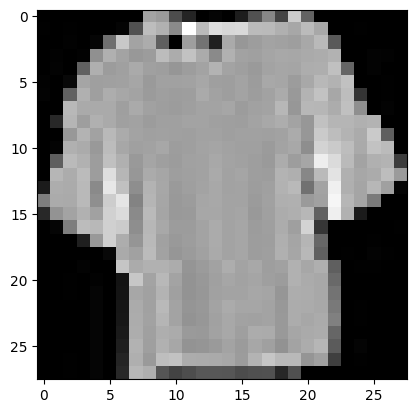

In [31]:
plt.imshow(binary_train_ds[20][0][0], cmap="grey")

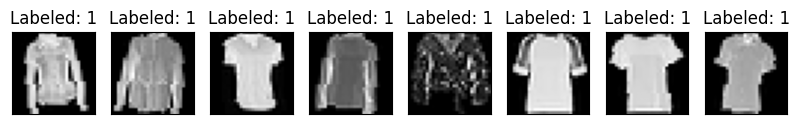

In [32]:
n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

#모듈 생성

In [33]:
from torch.nn import Module
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout2d, Dropout, Linear, BatchNorm2d, BatchNorm1d
from torch import cat

In [34]:
torch.set_default_dtype(torch.float64)
class BinaryClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = BatchNorm2d(32)
        self.conv2 = Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = BatchNorm2d(64)
        self.dropout1 = Dropout2d(p=0.2)

        self.fc1 = Linear(64*7*7, 8)
        self.dropout2 = Dropout(p=0.2)
        self.bn4 = BatchNorm1d(8)
        self.fc2 = Linear(1, 1)

        torch.nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.xavier_normal_(self.fc2.weight)
        
        # Quantum layer
        self.q_device = qml.device("default.qubit", wires=8)
        self.qnn_params = Parameter(0.5*torch.randn(42), requires_grad= True)
        self.obs = qml.PauliZ(7)

        @qml.qnode(self.q_device)
        def circuit(x):
            #Feature Encoding
            qml.AngleEmbedding(x, range(8), rotation="Y")
            #---------------
            #Convolution1
            for i in range(4):
              qml.CNOT(wires=[i*2, i*2+1])
            for i in range(8):
              qml.RY(self.qnn_params[i], wires=i)
            for i in range(4):
              qml.CNOT(wires=[i*2+1, (i*2+2)%8])

            for i in range(4):
              qml.CNOT(wires=[i*2, i*2+1])
            for i in range(8):
              qml.RX(self.qnn_params[i+8], wires=i)
            for i in range(4):
              qml.CNOT(wires=[i*2+1, (i*2+2)%8])
            #---------------
            #Pooling1
            for i in range(4):
              qml.CNOT(wires=[i*2+1, i*2])
            for i in range(8):
              qml.RZ(self.qnn_params[i+16], wires=i)
            for i in range(4):
              qml.CNOT(wires=[i*2, i*2+1])
            #----------------
            #Convolution2
            for i in range(2):
              qml.CNOT(wires=[i*4+1, i*4+3])
            for i in range(4):
              qml.RY(self.qnn_params[i+24], wires=2*i+1)
            for i in range(2):
              qml.CNOT(wires=[i*4+3, (i*4+5)%8])

            for i in range(2):
              qml.CNOT(wires=[i*4+1, i*4+3])
            for i in range(4):
              qml.RX(self.qnn_params[i+28], wires=2*i+1)
            for i in range(2):
              qml.CNOT(wires=[i*4+3, (i*4+5)%8])
            #---------------
            #Pooling2
            for i in range(2):
              qml.CNOT(wires=[i*4+3, i*4+1])
            for i in range(4):
              qml.RZ(self.qnn_params[i+32], wires=i*2+1)
            for i in range(2):
              qml.CNOT(wires=[i*4+1, i*4+3])
            #---------------
            #Convolution3
            qml.CNOT(wires=[7, 3])
            qml.RY(self.qnn_params[36], wires=3)
            qml.RY(self.qnn_params[37], wires=7)
            qml.CNOT(wires=[3, 7])

            qml.CNOT(wires=[7, 3])
            qml.RX(self.qnn_params[38], wires=3)
            qml.RX(self.qnn_params[39], wires=7)
            qml.CNOT(wires=[3, 7])
            #---------------
            #Pooling3
            qml.CNOT(wires=[7, 3])
            qml.RZ(self.qnn_params[40], wires=3)
            qml.RZ(self.qnn_params[41], wires=7)
            qml.CNOT(wires=[3, 7])

            return qml.expval(self.obs)

        self.qnn = circuit

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = x.view(-1,64*7*7)
        x = F.relu(self.fc1(x))
        x = self.bn4(x)
        x = self.dropout2(x)
        x = self.qnn(x).view(-1,1)  # apply QNN
        x = self.fc2(x)
        return F.log_softmax(cat((x, 1 - x), -1), -1)

In [35]:
bc = BinaryClassifier()

bc = bc.to(device)

#회로 제약 점검

In [36]:
# ───── 학습 전에 회로 제약 먼저 점검 ─────
import pennylane as qml, torch

dummy_x = torch.tensor(torch.randn(2,8), dtype=torch.float64)
specs = qml.specs(bc.qnn)(dummy_x)

specs

C:\Users\xanle\AppData\Local\Temp\ipykernel_9112\3286975387.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dummy_x = torch.tensor(torch.randn(2,8), dtype=torch.float64)


{'resources': Resources(num_wires=8, num_gates=85, gate_types=defaultdict(<class 'int'>, {'AngleEmbedding': 1, 'CNOT': 42, 'RY': 14, 'RX': 14, 'RZ': 14}), gate_sizes=defaultdict(<class 'int'>, {8: 1, 2: 42, 1: 42}), depth=28, shots=Shots(total_shots=None, shot_vector=())),
 'errors': {},
 'num_observables': 1,
 'num_trainable_params': 42,
 'num_device_wires': 8,
 'num_tape_wires': 8,
 'device_name': 'default.qubit',
 'level': 'gradient',
 'gradient_options': {},
 'interface': 'auto',
 'diff_method': 'best',
 'gradient_fn': 'backprop'}

In [37]:
# prompt: bc의 전체 학습 가중치 파라미터 개수를 알라보려면? 영어로 출력

total_params = sum(p.numel() for p in bc.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


print("num_tape_wires:"+str(specs["num_tape_wires"]))
print("resources:" + str(specs['resources'].depth))
print("num_trainable_params:"+str(specs["num_trainable_params"]))

assert specs["num_tape_wires"] <= 8,  "❌ 큐빗 수 초과"
assert specs['resources'].depth <= 30, "❌ 회로 깊이 초과"
assert specs["num_trainable_params"]<= 60, "❌ 학습 파라미터 수 초과"
assert total_params <= 50000, "❌ 학습 전체 파라미터 수 초과"

print("✅ 회로 제약 통과 — 학습을 계속합니다")

Total number of trainable parameters: 44164
num_tape_wires:8
resources:28
num_trainable_params:42
✅ 회로 제약 통과 — 학습을 계속합니다


In [38]:
data, target = next(iter(train_loader))

In [39]:
optimizer = AdamW(bc.parameters(), lr=1e-3)
loss_func  = NLLLoss()

loss_history = []
bc.train()

BinaryClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=3136, out_features=8, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1, out_features=1, bias=True)
)

# 모델 학습 및 추론

In [40]:
param_file_name= "my_model1_params"

In [41]:
from datetime import datetime
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bc.to(device)
iteration_history = []
optimizer_type = ""

epochs = 1
max_iterations = 1000
stop_acc_threshold = 0.1

theta = 0.3
RAdam_iter = 5
RAdam_counter = 0
RAdam_use = True

skip_initial_training = False

acc_max = 0

bc.train()

##########################################################################
#초기 학습

if(RAdam_use):
  optimizer = RAdam(bc.parameters(), lr=3e-4)
  optimizer_type = "RAdam"
  
else:
  optimizer = AdamW(bc.parameters(), lr=1e-4, weight_decay = 1e-4)
  optimizer_type = "AdamW"

while not skip_initial_training:
  if RAdam_use:
    RAdam_counter += 1
    if RAdam_counter > RAdam_iter:
      optimizer = AdamW(bc.parameters(), lr=1e-4)
      optimizer_type = "AdamW"
      RAdam_use = False

  clear_output(wait=True)
  epoch_bar = tqdm(range(len(train_loader)),
                  desc=f"Epoch (just training, optimizer:{optimizer_type})",
                  leave=False)   # leave=False면 다음 에폭 때 덮어씀

  total_loss = []
  for bidx, (data, target) in zip(epoch_bar, train_loader):
      optimizer.zero_grad(set_to_none=True)
      data, target = data.to(device), target.to(device)
      output = bc(data)
      loss   = loss_func(output, target.squeeze())

      total_loss.append(loss.item())
      loss.backward()
      optimizer.step()

      # 20배치마다 postfix로 현재 상태 표시
      if bidx % 20 == 0:
          epoch_bar.set_postfix(batch=bidx,
                                loss=f"{loss.item():.4f}")

  # 에폭 끝나면 전체 loss 기록
  avg_loss = sum(total_loss) / len(total_loss)
  loss_history.append(avg_loss)

  # 에폭 요약 한 줄 출력 (leave=False였으면 이게 마지막 줄로 남음)
  print(f"Training "
        f"Loss: {avg_loss:.4f}")

  if avg_loss < theta:
    break

##########################################################################
### 학습 및 평가
#if skip_initial_training:
optimizer = Lion(bc.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay = 1e-2)
optimizer_type = "Lion"

iteration = 0
while True:
  if iteration >= max_iterations:
    break
  bc.train()
  for epoch in range(epochs):
      if iteration == 0 and epoch == 1 and epochs >= 2 or epochs == 1 and iteration == 1:
        optimizer = Lookahead(optimizer)
        optimizer_type = "Lookahead Lion"
      # 에폭 진행률 바
      epoch_bar = tqdm(range(len(train_loader)),
                      desc=f"Epoch(optimizer:{optimizer_type}) {epoch+1}/{epochs}",
                      leave=False)   # leave=False면 다음 에폭 때 덮어씀

      total_loss = []
      for bidx, (data, target) in zip(epoch_bar, train_loader):
          optimizer.zero_grad(set_to_none=True)
          data, target = data.to(device), target.to(device)
          output = bc(data)
          loss   = loss_func(output, target.squeeze())

          total_loss.append(loss.item())
          loss.backward()
          optimizer.step()

          # 20배치마다 postfix로 현재 상태 표시
          if bidx % 20 == 0:
              epoch_bar.set_postfix(batch=bidx,
                                    loss=f"{loss.item():.4f}")

      # 에폭 끝나면 전체 loss 기록
      avg_loss = sum(total_loss) / len(total_loss)
      loss_history.append(avg_loss)

      # 에폭 요약 한 줄 출력 (leave=False였으면 이게 마지막 줄로 남음)
      print(f"Training [{100.0 * (epoch+1)/epochs:.0f}%] "
            f"Loss: {avg_loss:.4f}")


  ### 모델 추론
  test_loader = DataLoader(
      test_ds,
      batch_size=64,
      shuffle=False
  )

  bc.eval()

  all_preds, all_targets = [], []

  with torch.no_grad():
      for data, target in tqdm(test_loader,
                              desc="Inference",
                              total=len(test_loader),
                              leave=False):
          data, target = data.to(device), target.to(device)

          logits = bc(data)

          pred = logits.argmax(dim=1)

          all_preds.append(pred.cpu())
          all_targets.append(target.view(-1).cpu())

  y_pred = torch.cat(all_preds).numpy().astype(int)
  y_true = torch.cat(all_targets).numpy().astype(int)

  ### 평가 및 결과 저장
  # 0·6 라벨만 평가
  test_mask = (y_true == 0) | (y_true == 6)

  # print("total samples:", len(y_true))
  # print("target samples:", test_mask.sum())

  # 모델 결과가 1인 것을 6으로 변경
  y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

  acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
  iteration_history.append([avg_loss, acc])
  clear_output(wait=True)
  for i in range(len(iteration_history)):
    print(f"Iteration [{i+1}/{max_iterations}], "
          f"Loss: {iteration_history[i][0]:.4f}, "
          f"Accuracy: {iteration_history[i][1]:.4f}")


  # 현재 시각을 "YYYYMMDD_HHMMSS" 형식으로 포맷팅
  now = datetime.now().strftime("%Y%m%d_%H%M%S")
  os.makedirs("results", exist_ok=True)
  # 원본 파일명을 기반으로 새 파일명 생성
  y_pred_filename = f"results/y_pred_{now}_acc_{acc:.4f}.csv"
  np.savetxt(y_pred_filename, y_pred_mapped, fmt="%d")

  model_filename = f"results/{param_file_name}_{now}_acc_{acc:.4f}.pth"
  torch.save(bc.state_dict(), model_filename)
  if acc_max < acc:
    os.makedirs("results/best", exist_ok=True)
    model_filename = f"results/best/{param_file_name}_{now}_acc_{acc:.4f}_loss_{avg_loss:.4f}.pth"
    torch.save(bc.state_dict(), model_filename)
    acc_max = acc

  if acc <= stop_acc_threshold:
    break

  iteration = iteration + 1

Iteration [1/1000], Loss: 0.3118, Accuracy: 0.8805
Iteration [2/1000], Loss: 0.3124, Accuracy: 0.8780
Iteration [3/1000], Loss: 0.3032, Accuracy: 0.8820
Iteration [4/1000], Loss: 0.3090, Accuracy: 0.8820
Iteration [5/1000], Loss: 0.3092, Accuracy: 0.8880
Iteration [6/1000], Loss: 0.3053, Accuracy: 0.8800
Iteration [7/1000], Loss: 0.3174, Accuracy: 0.8740
Iteration [8/1000], Loss: 0.3183, Accuracy: 0.8840
Iteration [9/1000], Loss: 0.3185, Accuracy: 0.8845
Iteration [10/1000], Loss: 0.3118, Accuracy: 0.8780
Iteration [11/1000], Loss: 0.3100, Accuracy: 0.8890
Iteration [12/1000], Loss: 0.3036, Accuracy: 0.8780
Iteration [13/1000], Loss: 0.3092, Accuracy: 0.8860
Iteration [14/1000], Loss: 0.3028, Accuracy: 0.8885
Iteration [15/1000], Loss: 0.2967, Accuracy: 0.8835
Iteration [16/1000], Loss: 0.3015, Accuracy: 0.8840
Iteration [17/1000], Loss: 0.3025, Accuracy: 0.8865
Iteration [18/1000], Loss: 0.2968, Accuracy: 0.8805
Iteration [19/1000], Loss: 0.2974, Accuracy: 0.8845
Iteration [20/1000], 

KeyboardInterrupt: 

파라미터 로딩

In [ ]:
import os

if False:

  fn = "my_model1_params_20250801_062744_acc_0.8985.pth"
  state_dict = torch.load(f"results/start_params/{fn}", map_location=device)
  bc.load_state_dict(state_dict)
  bc = bc.to(device)

  bc.eval()

  test_loader = DataLoader(
        test_ds,
        batch_size=64,
        shuffle=False
    )

  all_preds, all_targets = [], []

  with torch.no_grad():
      for data, target in tqdm(test_loader,
                              desc="Inference",
                              total=len(test_loader),
                              leave=False):
          data, target = data.to(device), target.to(device)

          logits = bc(data)

          pred = logits.argmax(dim=1)

          all_preds.append(pred.cpu())
          all_targets.append(target.view(-1).cpu())

  y_pred = torch.cat(all_preds).numpy().astype(int)
  y_true = torch.cat(all_targets).numpy().astype(int)

  ### 평가 및 결과 저장
  # 0·6 라벨만 평가
  test_mask = (y_true == 0) | (y_true == 6)

  # print("total samples:", len(y_true))
  # print("target samples:", test_mask.sum())

  # 모델 결과가 1인 것을 6으로 변경
  y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

  acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
  print(f"acc: {acc} loaded")

acc: 0.8985 loaded
